In [1]:
%%capture
%load_ext autoreload
%autoreload 2
import pygmt
import verde as vd
import xarray as xr
import pandas as pd
import verde as vd
import numpy as np
import zarr
from antarctic_plots import fetch, regions, utils, maps


# Get sample data

In [2]:
layer_spacing = 5e3
buffer_region = [-580000, 420000, -1420000, -420000]
# buffer_region = utils.alter_region(buffer_region, zoom=200e3)[0]
constraints_fname = "../inversion_layers/ross_ice_shelf_bed_data.csv.gz"

constraints_full = pd.read_csv(
    constraints_fname,
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

constraints = utils.block_reduce(
    constraints_full,
    np.median,
    spacing = layer_spacing,
    input_data_names = ["z_ellipsoidal"],
    center_coordinates=False,
    adjust="region",
    drop_coords=False,
)

# ensure all points are within buffer region
constraints = utils.points_inside_region(
    constraints, 
    buffer_region, 
    names=("x", "y")
)

# set conventional names
constraint_points = constraints.rename(columns={
    "x":"easting","y":"northing", "z_ellipsoidal":"upward"})

print(f"bathymetry control points:{len(constraint_points)}")
constraint_points.describe()

bathymetry control points:21708


easting      northing        upward
count   21708.000000  2.170800e+04  21708.000000
mean   -94441.002055 -8.630958e+05     31.360308
std    331031.874772  3.434133e+05    994.292903
min   -579000.000000 -1.418000e+06  -3559.493408
25%   -400000.000000 -1.253000e+06   -638.285439
50%   -137000.000000 -7.375000e+05   -461.468040
75%    242000.000000 -5.625000e+05    583.111298
max    418000.000000 -4.220000e+05   3997.074341

# PyGMT
* grdfill

# Verde
* Spline
    * SplineCV
* KNeighbors
* Linear
* Cubic

In [421]:
# KNeighbors
grd = vd.KNeighbors(k=10, reduction=np.median)
grd.fit((constraint_points.easting, constraint_points.northing), constraint_points.upward)
grid = grd.grid(region=buffer_region, spacing=layer_spacing).scalars
grd.score((constraint_points.easting, constraint_points.northing), constraint_points.upward)

0.9855978968356176

returning original grid


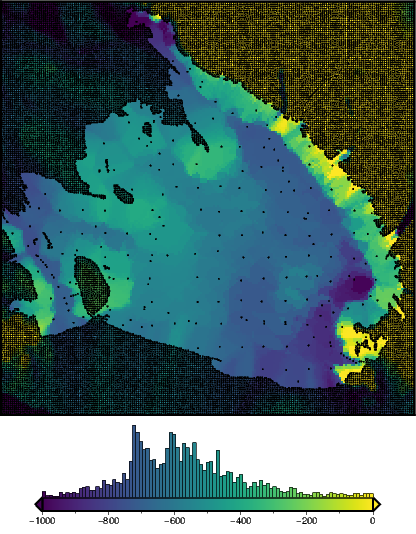

In [422]:
maps.plot_grd(
    grid, 
    points=constraint_points.rename(columns={"easting":"x","northing":"y"}),
    points_style="c0.05c",
    cpt_lims=[-1000,0],
    hist=True,
    )

In [423]:
# Linear
grd = vd.Linear(rescale = False)
grd.fit((constraint_points.easting, constraint_points.northing), constraint_points.upward)
grid = grd.grid(region=buffer_region, spacing=layer_spacing).scalars
grd.score((constraint_points.easting, constraint_points.northing), constraint_points.upward)

1.0

returning original grid


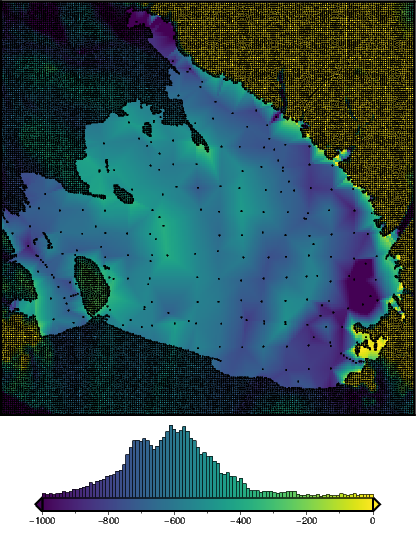

In [424]:
maps.plot_grd(
    grid, 
    points=constraint_points.rename(columns={"easting":"x","northing":"y"}),
    points_style="c0.05c",
    cpt_lims=[-1000,0],
    hist=True,
    )

In [425]:
# Spline
grd = vd.Spline(mindist=1e-5, damping=None)
grd.fit((constraint_points.easting, constraint_points.northing), constraint_points.upward)
grid = grd.grid(region=buffer_region, spacing=layer_spacing).scalars
grd.score((constraint_points.easting, constraint_points.northing), constraint_points.upward)
# 20mins

0.9999999999977891

returning original grid


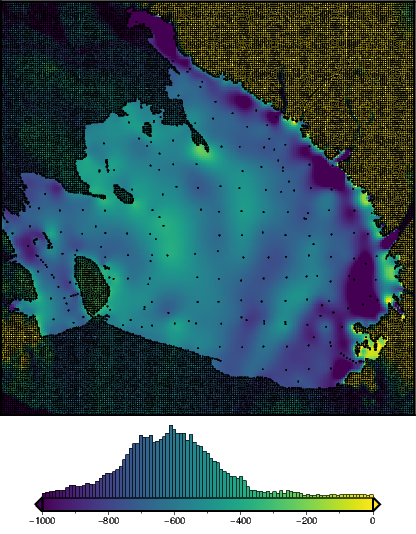

In [426]:
maps.plot_grd(
    grid, 
    points=constraint_points.rename(columns={"easting":"x","northing":"y"}),
    points_style="c0.05c",
    cpt_lims=[-1000,0],
    hist=True,
    )

In [427]:
# Cubic
grd = vd.Cubic(rescale=False)
grd.fit((constraint_points.easting, constraint_points.northing), constraint_points.upward)
grid = grd.grid(region=buffer_region, spacing=layer_spacing).scalars
grd.score((constraint_points.easting, constraint_points.northing), constraint_points.upward)

1.0

returning original grid


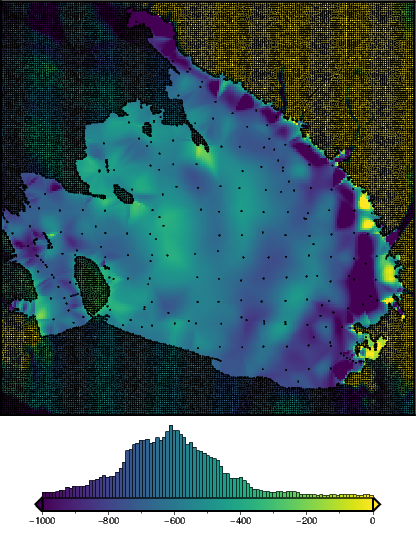

In [428]:
maps.plot_grd(
    grid, 
    points=constraint_points.rename(columns={"easting":"x","northing":"y"}),
    points_style="c0.05c",
    cpt_lims=[-1000,0],
    hist=True,
    )

# [GStatSim](https://github.com/GatorGlaciology/GStatSim)
* simple kriging
* ordinary kriding
* sequential gaussian w/ simple kriging
* sequential gaussian w/ ordinary kriging
* others

cloned and installed locally
```
    git clone https://github.com/GatorGlaciology/GStatSim 
    cd GStatSim
    pip install -e .
```
    
also need to install SciKit Gstat
```
    mamba install scikit-gstat
```

In [399]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
import skgstat as skg
from skgstat import models
import gstatsim as gs
# from plot_utils import splot2D, mplot1, mplot2_std

In [406]:
# get data in right format
df_bed = constraint_points.rename(columns = {
    "easting": "X",
    "northing": "Y",
    "upward": "Bed",
    })

# grid data to desired resolution and remove coordinates with NaNs
res = layer_spacing
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'X', 'Y', 'Bed', res)
df_grid = df_grid[df_grid["Z"].isnull() == False]
df_grid = df_grid.rename(columns = {"Z": "Bed"})

df_grid.describe()

X             Y          Sum        Count          Bed
count    1491.000000  1.491000e+03  1491.000000  1491.000000  1491.000000
mean  -124507.042254 -7.965426e+05   -46.517367     1.443327   -30.210678
std    217756.348471  1.935609e+05  1393.672497     0.673547   888.342883
min   -380000.000000 -1.220000e+06 -3617.026154     1.000000 -1749.476501
25%   -330000.000000 -8.900000e+05  -701.194977     1.000000  -569.000000
50%   -195000.000000 -7.000000e+05  -511.206421     1.000000  -462.393005
75%    120000.000000 -6.600000e+05   188.898968     2.000000   152.752615
max    215000.000000 -6.250000e+05  8064.986267     4.000000  3977.883911

In [401]:
# normal score transformation
data = df_grid['Bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data)
df_grid['Nbed'] = nst_trans.transform(data) 

df_grid.describe()

X             Y          Sum        Count          Bed  \
count    1491.000000  1.491000e+03  1491.000000  1491.000000  1491.000000   
mean  -124507.042254 -7.965426e+05   -46.517367     1.443327   -30.210678   
std    217756.348471  1.935609e+05  1393.672497     0.673547   888.342883   
min   -380000.000000 -1.220000e+06 -3617.026154     1.000000 -1749.476501   
25%   -330000.000000 -8.900000e+05  -701.194977     1.000000  -569.000000   
50%   -195000.000000 -7.000000e+05  -511.206421     1.000000  -462.393005   
75%    120000.000000 -6.600000e+05   188.898968     2.000000   152.752615   
max    215000.000000 -6.250000e+05  8064.986267     4.000000  3977.883911   

              Nbed  
count  1491.000000  
mean     -0.000143  
std       1.012254  
min      -5.199338  
25%      -0.673492  
50%       0.000273  
75%       0.675933  
max       5.199338

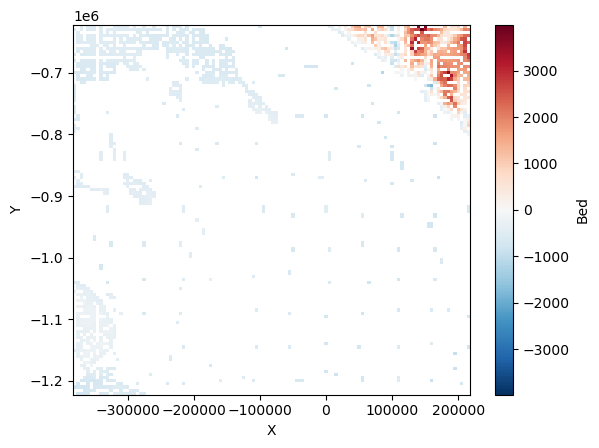

In [403]:
df_grid.set_index(["Y", "X"]).to_xarray().Bed.plot()

In [234]:
# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nbed']

maxlag = 100000             # maximum range distance
n_lags = 70                # num of bins

V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, 
                   maxlag=maxlag, normalize=False)

# use exponential variogram model
V1.model = 'exponential'
V1.parameters

[99999.99999993938, 0.9056896154907631, 0]

In [404]:
# define coordinate grid
xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

Pred_grid_xy = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)
np.shape(Pred_grid_xy)

(14400, 2)

In [419]:
Pred_grid_xy

array([[ -380000.,  -625000.],
       [ -375000.,  -625000.],
       [ -370000.,  -625000.],
       ...,
       [  205000., -1220000.],
       [  210000., -1220000.],
       [  215000., -1220000.]])

In [236]:
# set variogram parameters
azimuth = 0
nugget = V1.parameters[2]

# the major and minor ranges are the same in this example because it is isotropic
major_range = V1.parameters[0]
minor_range = V1.parameters[0]
sill = V1.parameters[1]

# save variogram parameters as a list
vario = [azimuth, nugget, major_range, minor_range, sill]


k = 10         # number of neighboring data points used to estimate a given point
rad = 100000     # 50 km search radius

# est_SK is the estimate and var_SK is the variance
est_SK, var_SK = gs.Interpolation.skrige(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad)

100%|██████████| 3600/3600 [00:26<00:00, 136.06it/s]


In [237]:
# reverse normal score transformation

var_SK[var_SK < 0] = 0      # make sure variances are non-negative
std_SK = np.sqrt(var_SK)    # convert to standard deviation before back transforming

# reshape
est = est_SK.reshape(-1,1)
std = std_SK.reshape(-1,1)

In [238]:
coords = vd.grid_coordinates(
        region=buffer_region,
        spacing=layer_spacing,
        pixel_register=True,
    )
grid = vd.make_xarray_grid(
    (coords[0], coords[1]), 
    data=np.ones_like(coords[0]), 
    data_names="dummy"
    )

grid_df = vd.grid_to_table(grid)
grid_df

northing   easting  dummy
0    -1215000.0 -375000.0    1.0
1    -1215000.0 -365000.0    1.0
2    -1215000.0 -355000.0    1.0
3    -1215000.0 -345000.0    1.0
4    -1215000.0 -335000.0    1.0
...         ...       ...    ...
3595  -625000.0  175000.0    1.0
3596  -625000.0  185000.0    1.0
3597  -625000.0  195000.0    1.0
3598  -625000.0  205000.0    1.0
3599  -625000.0  215000.0    1.0

[3600 rows x 3 columns]

In [239]:
# back transformation
grid_df["spred_trans"] = nst_trans.inverse_transform(est)
sstd_trans = nst_trans.inverse_transform(std)
grid_df["sstd_trans"] = sstd_trans - np.min(sstd_trans)

gstat_grid = grid_df.set_index(["northing", "easting"]).to_xarray()
gstat_grid

<xarray.Dataset>
Dimensions:      (northing: 60, easting: 60)
Coordinates:
  * northing     (northing) float64 -1.215e+06 -1.205e+06 ... -6.25e+05
  * easting      (easting) float64 -3.75e+05 -3.65e+05 ... 2.05e+05 2.15e+05
Data variables:
    dummy        (northing, easting) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    spred_trans  (northing, easting) float64 -472.7 -459.3 ... -653.7 -638.0
    sstd_trans   (northing, easting) float64 207.7 0.0 0.0 ... 265.2 238.5 216.8

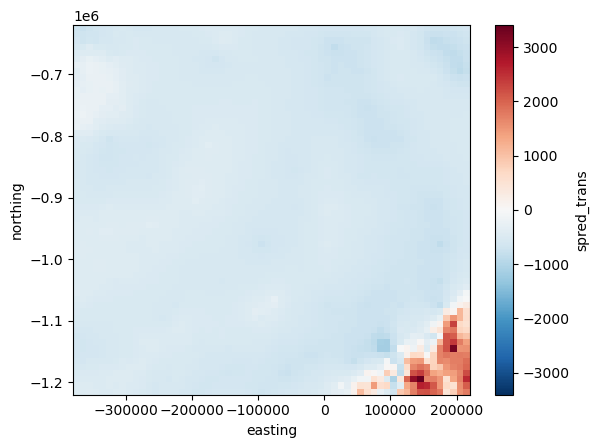

In [240]:
gstat_grid.spred_trans.plot()

In [241]:
# maps.plot_grd(
#     gstat_grid.spred_trans, 
#     points=constraint_points.rename(columns={"easting":"x","northing":"y"}),
#     points_style="c0.05c",
#     cpt_lims=[-1000,0],
#     hist=True,
#     )

# [PyKrige](https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/) / GSTools
* kriging
* random field generation

# [PyInterp](https://pangeo-pyinterp.readthedocs.io/en/latest/api.html)
* geo-referenced interpolation
* 1 - 4 D interpolation
    * [bicubic](https://pangeo-pyinterp.readthedocs.io/en/latest/generated/pyinterp.bicubic.html#pyinterp.bicubic)
    * [bivariate](https://pangeo-pyinterp.readthedocs.io/en/latest/generated/pyinterp.bivariate.html#pyinterp.bivariate)
    * [trivariate](https://pangeo-pyinterp.readthedocs.io/en/latest/generated/pyinterp.trivariate.html#pyinterp.trivariate)
    * ~~[quadvariate]~~
* support xarray grids
    * [xarray.Grid2D](https://pangeo-pyinterp.readthedocs.io/en/latest/generated/pyinterp.backends.xarray.Grid2D.html#pyinterp.backends.xarray.Grid2D)
    * 
* fill NaN's
    * [loess](https://pangeo-pyinterp.readthedocs.io/en/latest/generated/pyinterp.fill.loess.html#pyinterp.fill.loess)
    * [gaus-seidel](https://pangeo-pyinterp.readthedocs.io/en/latest/generated/pyinterp.fill.gauss_seidel.html#pyinterp.fill.gauss_seidel)


In [249]:
import pyinterp
import pyinterp.backends.xarray
import pyinterp.fill

## Fill NaN's

Y         X          Bed
0     -1220000.0 -380000.0          NaN
1     -1220000.0 -375000.0  -756.834686
2     -1220000.0 -370000.0  -741.476746
3     -1220000.0 -365000.0  -713.450714
4     -1220000.0 -360000.0  -701.389954
...          ...       ...          ...
11643  -625000.0  195000.0   503.500000
11644  -625000.0  200000.0   919.476990
11645  -625000.0  205000.0          NaN
11646  -625000.0  210000.0  1390.316040
11647  -625000.0  215000.0          NaN

[11648 rows x 3 columns]

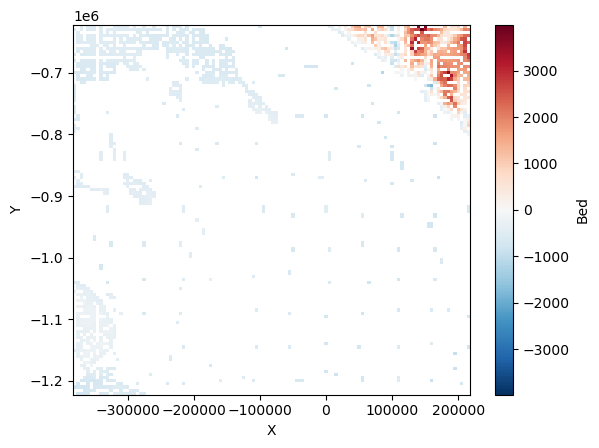

In [408]:
xr_grid = df_grid.set_index(["Y", "X"]).to_xarray().Bed
xr_grid.plot()
df = vd.grid_to_table(xr_grid)
df

In [409]:
xr_grid

<xarray.DataArray 'Bed' (Y: 104, X: 112)>
array([[          nan, -756.83468628, -741.47674561, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [-749.41384888, -754.01257324, -737.81736755, ...,           nan,
                  nan,           nan],
       ...,
       [          nan, -469.33325195,           nan, ...,           nan,
                  nan,           nan],
       [-463.93334961,           nan, -461.31815338, ..., 1332.31414795,
        1981.98443604, 1898.7562561 ],
       [          nan,           nan, -442.57083893, ...,           nan,
        1390.31604004,           nan]])
Coordinates:
  * Y        (Y) float64 -1.22e+06 -1.215e+06 -1.21e+06 ... -6.3e+05 -6.25e+05
  * X        (X) float64 -3.8e+05 -3.75e+05 -3.7e+05 ... 2.1e+05 2.15e+05

In [416]:
grid = pyinterp.backends.xarray.Grid2D(xr_grid,geodetic = False, )

# filled = pyinterp.fill.loess(
#     grid, 
#     nx=10, 
#     ny=10,
#     value_type="defined",
#     )
filled = pyinterp.fill.gauss_seidel(
    grid, 
    first_guess="zero", #"zonal_average",
    # max_iteration=100,
    epsilon=1e-4, # 1e-4 by default
    relaxation=None # None by default
    )[-1]

array([[-753.63260223, -756.83468628, -741.47674561, ..., -720.04808592,
        -716.56756429, -715.76270583],
       [-750.43048534, -749.33775224, -736.07324431, ..., -717.71539751,
        -715.22973273, -714.95784187],
       [-749.41384888, -754.01257324, -737.81736755, ..., -708.41852306,
        -711.67812018, -713.60919926],
       ...,
       [-471.52786798, -469.33325195, -466.29492875, ..., 1561.06394734,
        1951.93904081, 2022.9963433 ],
       [-463.93334961, -462.96534841, -461.31815338, ..., 1332.31414795,
        1981.98443604, 1898.7562561 ],
       [-460.60498864, -457.27663802, -442.57083893, ..., 1243.60534614,
        1390.31604004, 1644.53616753]])

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.10/site-packages/pygmt/clib/conversion.py:107: RuntimeWarning: Grid may have irregular spacing in the 'X' dimension, but GMT only supports regular spacing. Calculated regular spacing 5360.360360360361 is assumed in the 'X' dimension.
  warnings.warn(msg, category=RuntimeWarning)
/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.10/site-packages/pygmt/clib/conversion.py:107: RuntimeWarning: Grid may have irregular spacing in the 'Y' dimension, but GMT only supports regular spacing. Calculated regular spacing 5776.699029126214 is assumed in the 'Y' dimension.
  warnings.warn(msg, category=RuntimeWarning)
/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.10/site-packages/pygmt/clib/conversion.py:107: RuntimeWarning: Grid may have irregular spacing in the 'X' dimension, but GMT only supports regular spacing. Calculated regular spacing 5360.360360360361 is assumed in the 'X' dimension.
  warnings.war

returning original grid


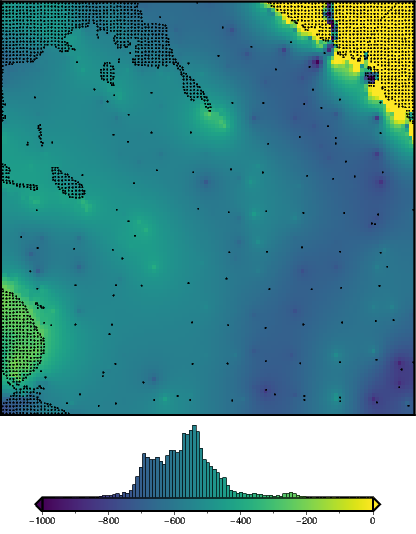

In [418]:
df['filled']=filled.ravel()
grid = df.set_index(["Y", "X"]).to_xarray().filled

maps.plot_grd(
    grid, 
    points=constraint_points.rename(columns={"easting":"x","northing":"y"}),
    points_style="c0.05c",
    cpt_lims=[-1000,0],
    hist=True,
    )

## Unstructured grid

In [405]:
constraint_points

easting      northing       upward
138010 -377000.000000 -1.217500e+06  -756.834686
138011 -372000.000000 -1.218000e+06  -741.476746
138012 -367000.000000 -1.217500e+06  -713.450714
138013 -362000.000000 -1.218000e+06  -701.389954
138014 -357000.000000 -1.217000e+06  -671.194702
...               ...           ...          ...
192644  197073.449058 -6.220062e+05   342.633911
192645  202000.000000 -6.220000e+05   505.085693
192646  208000.000000 -6.225000e+05  1017.415588
192647  213000.000000 -6.220000e+05  1445.485962
192648  218000.000000 -6.225000e+05  1769.872192

[2277 rows x 3 columns]

In [407]:
xr_grid

<xarray.DataArray 'Bed' (Y: 54, X: 57)>
array([[          nan, -748.95410156, -708.34136963, ...,           nan,
                  nan,           nan],
       [          nan,           nan, -670.67410278, ...,           nan,
                  nan, -680.        ],
       [          nan, -694.61988831, -651.10575358, ...,           nan,
                  nan,           nan],
       ...,
       [          nan,           nan, -493.6036377 , ...,           nan,
        1708.81500244, 2569.83105469],
       [          nan, -474.18321228, -476.62807719, ...,  521.59790039,
        1577.12390137,           nan],
       [          nan, -459.26245117, -445.20367432, ...,  812.21691895,
                  nan, 1778.6427002 ]])
Coordinates:
  * Y        (Y) float64 -1.22e+06 -1.21e+06 -1.2e+06 ... -6.4e+05 -6.3e+05
  * X        (X) float64 -3.8e+05 -3.7e+05 -3.6e+05 ... 1.9e+05 2e+05 2.1e+05

In [328]:
df = vd.grid_to_table(xr_grid)
df

Y         X          Bed
0    -1220000.0 -380000.0          NaN
1    -1220000.0 -370000.0  -748.954102
2    -1220000.0 -360000.0  -708.341370
3    -1220000.0 -350000.0          NaN
4    -1220000.0 -340000.0          NaN
...         ...       ...          ...
3073  -630000.0  170000.0  1795.204407
3074  -630000.0  180000.0   470.912292
3075  -630000.0  190000.0   812.216919
3076  -630000.0  200000.0          NaN
3077  -630000.0  210000.0  1778.642700

[3078 rows x 3 columns]

In [333]:
np.shape(np.array((df.X, df.Y)).T)

(3078, 2)

In [335]:
mesh = pyinterp.RTree()

mesh.packing(
    np.array((df.X, df.Y)).T, 
    df.Bed,
)
# mesh.packing(
#     np.vstack((constraint_points.easting, constraint_points.northing)).T, 
#     constraint_points.upward,
# )

In [340]:
# coords = vd.grid_coordinates(
#         region=buffer_region,
#         spacing=layer_spacing,
#         pixel_register=False,
#     )
# idw, neighbors = mesh.inverse_distance_weighting(
#     np.vstack((coords[0].ravel(), coords[1].ravel())).T,
#     within=False,  # Extrapolation is forbidden
#     k=11,  # We are looking for at most 11 neighbors
#     num_threads=0)
# idw = idw.reshape(coords[0].shape)

In [346]:
idw, neighbors = mesh.inverse_distance_weighting(
    np.array((df.X, df.Y)).T, 
    within=False,  # Extrapolation is forbidden
    k=11,  # We are looking for at most 11 neighbors
    num_threads=0)
df['idw'] = idw
# np.shape(idw)
# idw = idw.reshape(coords[0].shape)

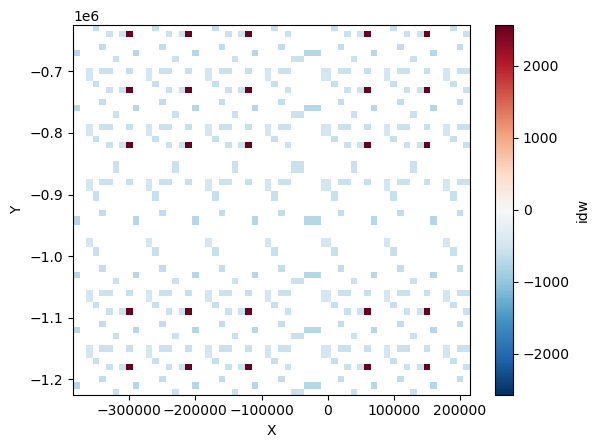

In [347]:
df.set_index(["Y", "X"]).to_xarray().idw.plot()

In [348]:
# grid = vd.make_xarray_grid(
#     (coords[0], coords[1]), 
#     data=idw, 
#     data_names="idw"
#     )
# grid.idw.plot()
# # grid_df = vd.grid_to_table(grid)
# # grid_df

# Xarray-Extras.interpolate
* splev
* splrep
    * nearest neighbour
    * linear
    * quadratic
    * cubic
> Note: seems to be just for regridding!

In [ ]:
# from xarray_extras import splev, splrep

# xESMF
* regridding of numpy or xarray, include entire datasets
* uses dask for parallel computing
* 6 options
    * bilinear (monotonic)
    * conservative (monotonic)
    * conservative-normed
    * patch (very smooth, but slow)
    * nearest-s2d
    * nearest-d2s
* defining re-gridder is seperate from gridding (can reuse)
    * computing the regridding weights is the slow part, gridding is fast
* allows masking of NaNs
* provides commandline tools for grids too large for memory

> Note: seems to be just for regridding!


In [135]:
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import numpy as np
# import xarray as xr
# import xesmf as xe

# PyResample
* [nearest neighbor](https://pyresample.readthedocs.io/en/latest/api/pyresample.future.resamplers.html#module-pyresample.future.resamplers.nearest)
* [elliptical weighted average](https://pyresample.readthedocs.io/en/latest/api/pyresample.ewa.html)
* [bilinear](https://pyresample.readthedocs.io/en/latest/api/pyresample.bilinear.html)
* see [Satpy-resampling](https://satpy.readthedocs.io/en/latest/resample.html) for examples
* works with numpy and xarray

> Note: seems to be just for regridding!

# Satpy
* nearest neighbor
* elliptical weighted averaging
* native
* bilinear

> Note: seems to be just for regridding!

# pyGeoStatistics
* kriging
* simulation

> Note: not much info in docs, not actively developed

# Xarray-Spatial
* proximity distance